#Proyecto de Analisis Multivariado
Integrantes del equipo:


*   
*   
*   Sánchez Palma Gabriel Antonio







#Predicción de posiciones en Fórmula 1 (2014-2024)

##Pregunta de investigación
> ¿Qué tanto influyen la posición de salida (grid), los puntos obtenidos, el rendimiento en clasificación, y el tiempo en pits en la posición final de un piloto durante una carrera de Fórmula 1 en el periodo 2014-2024?

 Predicción de posiciones en la Formula 1

En este proyecto vamos a analizar datos de la fórmula 1 para poder predecir la posición que un piloto tendrá.

El enfoque se dará de los periodos 2014 - 2021 y 2022 - 2024 ya que los reglamentos se han modificado y queremos analizar si estos tienen un impacto en las variables a estudiar

## ¿Cómo es una carrera de Fórmula 1?

Para familiarizarnos con las bases de datos y sus variables, veamos en qué consiste una carrera de fórmula 1

Cada año (*temporada*), se realizan distintas carreras al rededor del mundo (*rounds*) donde compiten equipos (*constructores*) con dos pilotos (*drivers*), con el objetivo de sumar los suficientes puntos para ganar los campenatos: constructores y pilotos

Cada carrera (*race*) se compone de:
* Tres prácticas libres (*fp*), donde los equipos y pilotos tienen una hora (cada día) para poner a prueba sus autos y tácticas encaminadas a la carrera

* *Qualifications* para determinar el la posición (*position*) en la 'parrilla' (*grid*). El mejor tiempo saldrá desde la posición 1

    * Una Qualy se divide en 3: Q's
    * Q1 donde compiten todos los equipos y se eliminan 5 pilotos;
    * Q2 se eliminan 5 pilotos;
    * Q3 los 10 pilotos restantes compiten para obtener el mejor tiempo

El piloto que obtenga la posición 1 en la Q3 se lleva la "pole position"

* La carrera; se compite por los puntos (los primeros diez sólo obtienen) que suman tanto para el campeonanto de construcutores y de pilotos. Cada circuito tiene una distancia y eso determina el número de vueltas (*laps*) a realizar

Teniendo contexto del funcionamiento, pasemos a describir las variables


#Carga del database y librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
results = pd.read_csv('results.csv')
qualifying = pd.read_csv('qualifying.csv')
pit_stops = pd.read_csv('pit_stops.csv')

def time_to_seconds(t):
    try:
        m, s = t.split(':')
        return int(m) * 60 + float(s)
    except:
        return None

qualifying[['q1_sec', 'q2_sec', 'q3_sec']] = qualifying[['q1', 'q2', 'q3']].applymap(time_to_seconds)
pit_summary = pit_stops.groupby(['raceId', 'driverId'])['milliseconds'].sum().reset_index()
pit_summary.rename(columns={'milliseconds': 'total_pit_time_ms'}, inplace=True)
merged = results.merge(qualifying[['raceId', 'driverId', 'q1_sec', 'q2_sec', 'q3_sec']], on=['raceId', 'driverId'], how='left')
merged = merged.merge(pit_summary, on=['raceId', 'driverId'], how='left')
merged = merged[['grid', 'points', 'laps', 'q1_sec', 'q2_sec', 'q3_sec', 'total_pit_time_ms', 'positionOrder']].dropna()

<ipython-input-2-4160511f567d>:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  qualifying[['q1_sec', 'q2_sec', 'q3_sec']] = qualifying[['q1', 'q2', 'q3']].applymap(time_to_seconds)


## 1 Descripción de las variables

- `grid`: Posición de salida del piloto en la parrilla.
- `points`: Puntos obtenidos en la carrera.
- `laps`: Número de vueltas completadas.
- `q1_sec`, `q2_sec`, `q3_sec`: Tiempos de clasificación en segundos.
- `total_pit_time_ms`: Tiempo total en pits en milisegundos.
- `positionOrder`: Posición final del piloto (objetivo).

In [16]:
merged.dtypes.to_frame(name='Tipo de dato').reset_index().rename(columns={'index': 'Variable'})


,Variable,Tipo de dato
0,grid,int64
1,points,float64
2,laps,int64
3,q1_sec,float64
4,q2_sec,float64
5,q3_sec,float64
6,total_pit_time_ms,float64
7,positionOrder,int64


La mayoría de variables son numéricas (int64 o float64), lo cual es ideal para análisis estadístico.

grid, laps y positionOrder son enteros, lo que indica que representan cantidades discretas.

points y los tiempos (q1_sec, etc.) son numericos reales, es decir, son datos continuos con decimales.

Ademas, no hay variables categóricas, lo cual facilita el análisis multivariado.

##2 Estadística descriptiva de las variables

In [3]:
# Descriptivo general
merged.describe()

,grid,points,laps,q1_sec,q2_sec,q3_sec,total_pit_time_ms,positionOrder
count,2601.000000,2601.000000,2601.000000,2601.000000,2601.000000,2601.000000,2.601000e+03,2601.000000
mean,5.431373,9.705498,57.994233,87.896552,87.174876,87.137557,1.809990e+05,6.821223
std,3.143736,8.038954,11.712533,12.514672,12.227678,12.491531,5.121502e+05,5.172481
min,0.000000,0.000000,2.000000,53.904000,53.787000,53.377000,1.743400e+04,1.000000
25%,3.000000,2.000000,53.000000,77.689000,77.328000,76.922000,2.563900e+04,3.000000
50%,5.000000,10.000000,57.000000,88.021000,87.148000,87.241000,4.582400e+04,5.000000
75%,8.000000,15.000000,69.000000,96.110000,95.606000,95.173000,6.446300e+04,9.000000
max,24.000000,50.000000,87.000000,131.081000,129.272000,129.776000,3.691821e+06,24.000000


## 3 Visualización de la variable dependiente

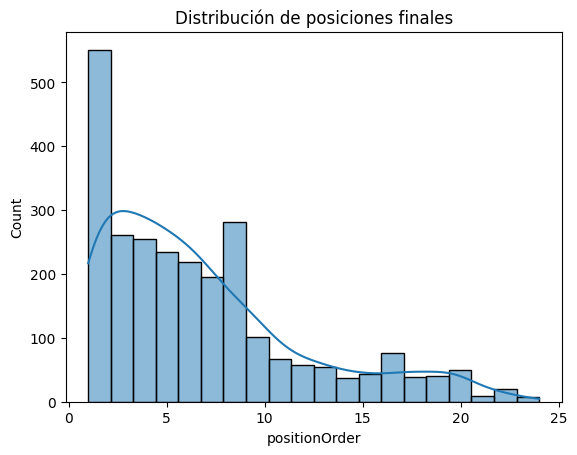

In [7]:
sns.histplot(merged['positionOrder'], bins=20, kde=True)
plt.title('Distribución de posiciones finales')
plt.show()

## 4️ Análisis univariado de las variables

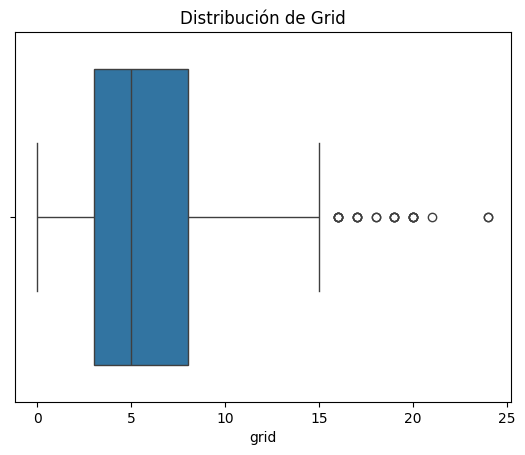

In [8]:
sns.boxplot(x=merged['grid'])
plt.title('Distribución de Grid')
plt.show()

## 5️ Análisis bivariado (PositionOrder con cada variable)

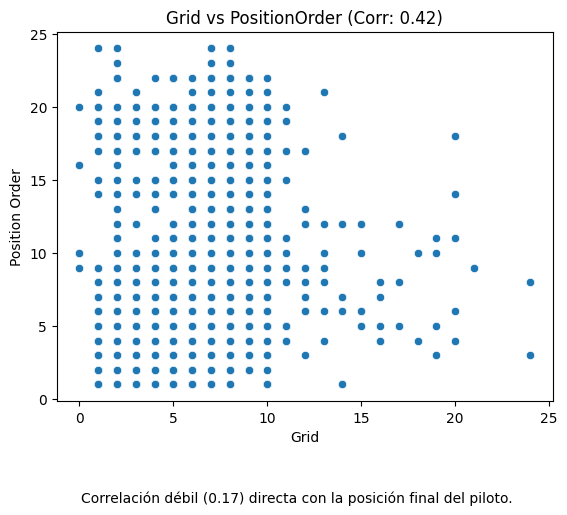

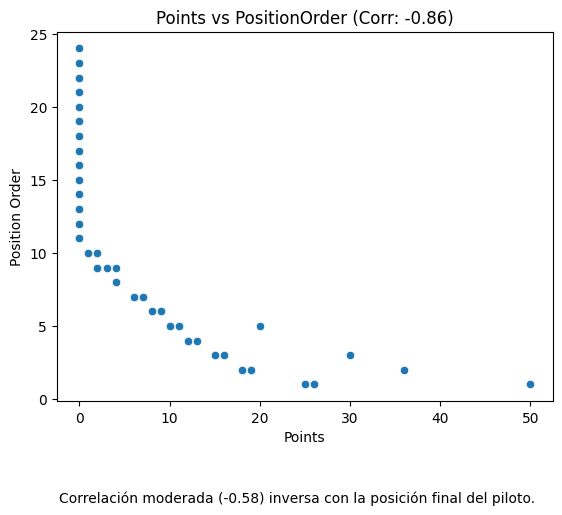

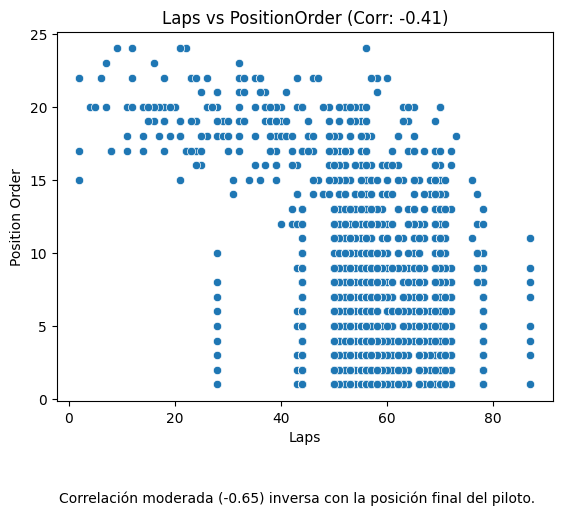

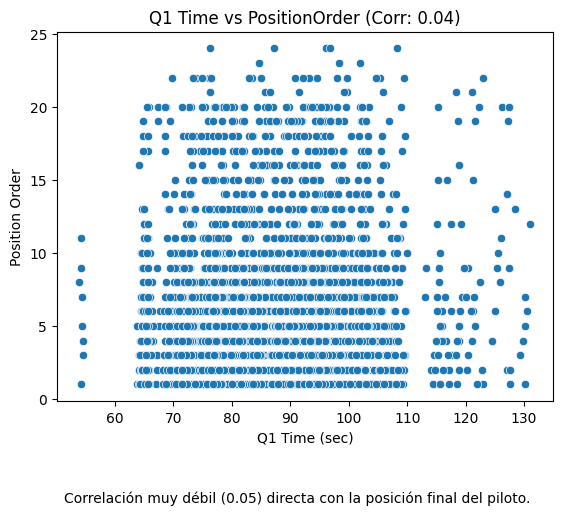

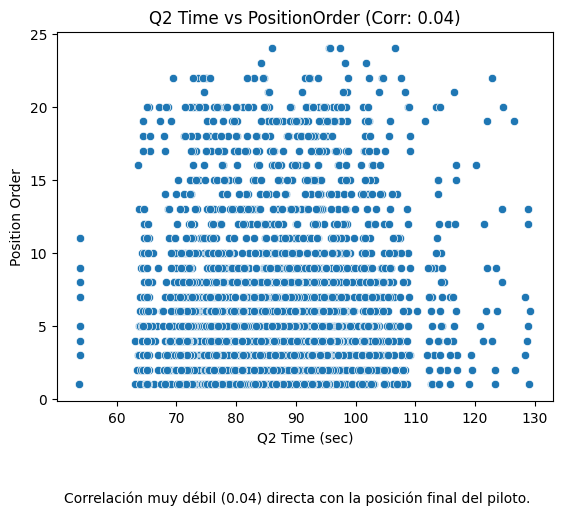

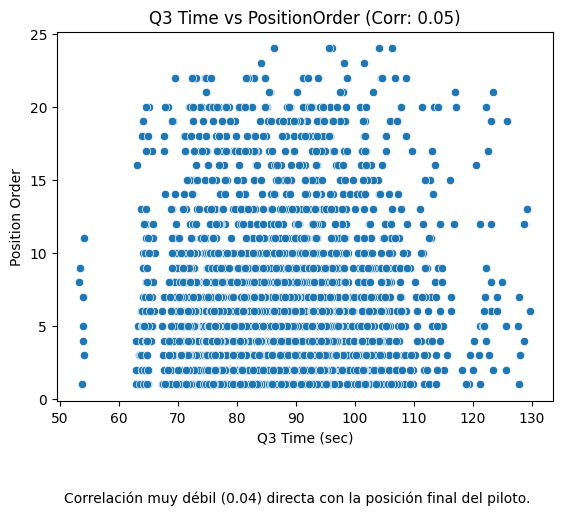

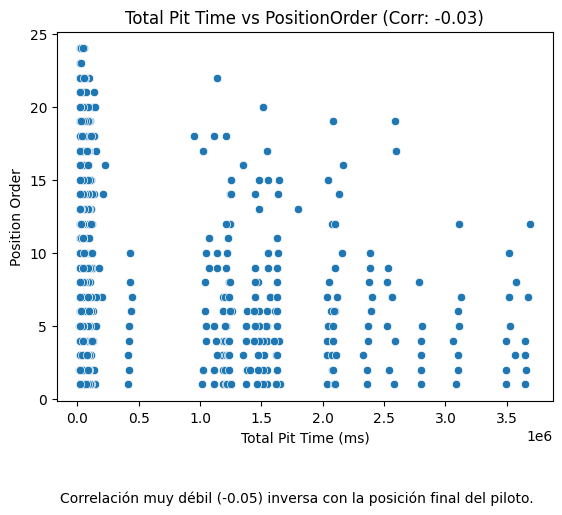

In [6]:
corr_grid = merged['grid'].corr(merged['positionOrder'])

sns.scatterplot(x=merged['grid'], y=merged['positionOrder'])
plt.title(f'Grid vs PositionOrder (Corr: {corr_grid:.2f})')
plt.xlabel('Grid')
plt.ylabel('Position Order')
plt.figtext(0.5, -0.1, "Correlación débil (0.17) directa con la posición final del piloto.", wrap=True, horizontalalignment='center')
plt.show()

corr_points = merged['points'].corr(merged['positionOrder'])

sns.scatterplot(x=merged['points'], y=merged['positionOrder'])
plt.title(f'Points vs PositionOrder (Corr: {corr_points:.2f})')
plt.xlabel('Points')
plt.ylabel('Position Order')
plt.figtext(0.5, -0.1, "Correlación moderada (-0.58) inversa con la posición final del piloto.", wrap=True, horizontalalignment='center')
plt.show()


corr_laps = merged['laps'].corr(merged['positionOrder'])

sns.scatterplot(x=merged['laps'], y=merged['positionOrder'])
plt.title(f'Laps vs PositionOrder (Corr: {corr_laps:.2f})')
plt.xlabel('Laps')
plt.ylabel('Position Order')
plt.figtext(0.5, -0.1, "Correlación moderada (-0.65) inversa con la posición final del piloto.", wrap=True, horizontalalignment='center')
plt.show()


corr_q1 = merged['q1_sec'].corr(merged['positionOrder'])

sns.scatterplot(x=merged['q1_sec'], y=merged['positionOrder'])
plt.title(f'Q1 Time vs PositionOrder (Corr: {corr_q1:.2f})')
plt.xlabel('Q1 Time (sec)')
plt.ylabel('Position Order')
plt.figtext(0.5, -0.1, "Correlación muy débil (0.05) directa con la posición final del piloto.", wrap=True, horizontalalignment='center')
plt.show()


corr_q2 = merged['q2_sec'].corr(merged['positionOrder'])

sns.scatterplot(x=merged['q2_sec'], y=merged['positionOrder'])
plt.title(f'Q2 Time vs PositionOrder (Corr: {corr_q2:.2f})')
plt.xlabel('Q2 Time (sec)')
plt.ylabel('Position Order')
plt.figtext(0.5, -0.1, "Correlación muy débil (0.04) directa con la posición final del piloto.", wrap=True, horizontalalignment='center')
plt.show()


corr_q3 = merged['q3_sec'].corr(merged['positionOrder'])

sns.scatterplot(x=merged['q3_sec'], y=merged['positionOrder'])
plt.title(f'Q3 Time vs PositionOrder (Corr: {corr_q3:.2f})')
plt.xlabel('Q3 Time (sec)')
plt.ylabel('Position Order')
plt.figtext(0.5, -0.1, "Correlación muy débil (0.04) directa con la posición final del piloto.", wrap=True, horizontalalignment='center')
plt.show()


corr_pit = merged['total_pit_time_ms'].corr(merged['positionOrder'])

sns.scatterplot(x=merged['total_pit_time_ms'], y=merged['positionOrder'])
plt.title(f'Total Pit Time vs PositionOrder (Corr: {corr_pit:.2f})')
plt.xlabel('Total Pit Time (ms)')
plt.ylabel('Position Order')
plt.figtext(0.5, -0.1, "Correlación muy débil (-0.05) inversa con la posición final del piloto.", wrap=True, horizontalalignment='center')
plt.show()


Estos gráficos muestran cómo se relaciona la posición final (positionOrder) con las demas variables independientes:

grid: Hay una tendencia débil directa.

points: Fuerte correlación inversa, ya que los mejores posicionados suman más puntos.

laps: Moderada correlación inversa, más vueltas completadas lo que resulta en una mejor posición.

q1, q2, q3: Muy baja correlación, lo que sugiere que la clasificación no determina el resultado final de la carrera.

total_pit_time_ms: Relación muy débil, aunque puede influir en casos extremos.

## 6️ Análisis multivariado (PCA)

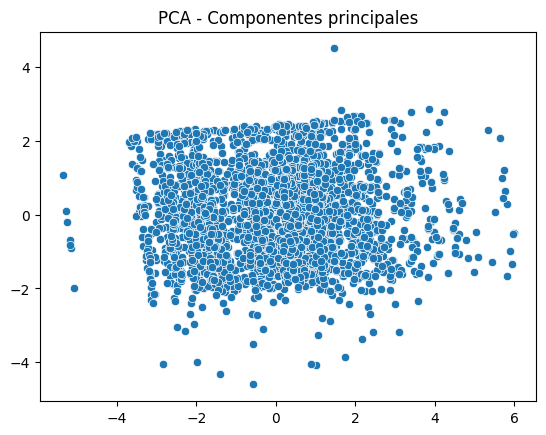

In [10]:
features = ['grid', 'points', 'laps', 'q1_sec', 'q2_sec', 'q3_sec', 'total_pit_time_ms']
X = StandardScaler().fit_transform(merged[features])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1])
plt.title('PCA - Componentes principales')
plt.show()

## 7️ Matriz de correlación

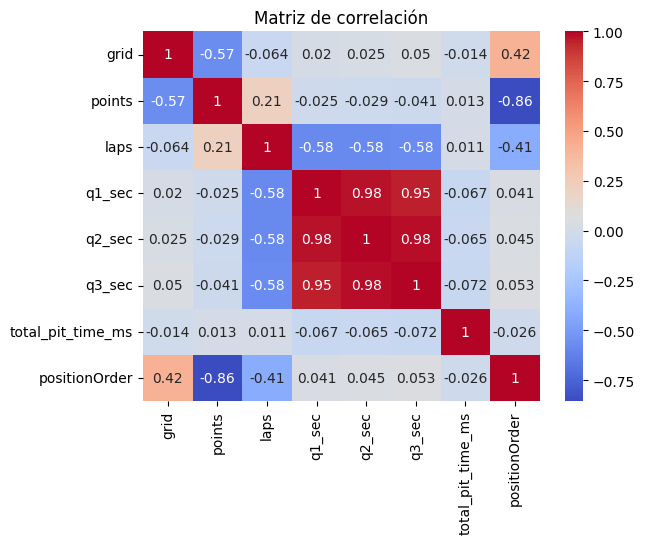

In [11]:
sns.heatmap(merged.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

La imagen muestra una matriz de correlación entre las variables numéricas del conjunto de datos. Esta matriz refleja qué tan correlaionadas están las variables entre sí, en cuanto a la variable dependiente positionOrder (posición final del piloto), se observan los siguientes patrones:

Existe una correlación negativa muy fuerte con la variable points (-0.86), lo que indica que los pilotos que terminan en mejores posiciones suelen obtener más puntos. Esto tiene sentido, ya que en la Fórmula 1 los puntos se otorgan a los mejores clasificados.

La variable grid (posición de salida) muestra una correlación moderada positiva (0.42) con la posición final. Es decir, cuanto más atrás parte un piloto, en promedio, peor es su resultado final.

La variable laps (vueltas completadas) tiene una correlación moderada negativa (-0.41) con la posición final, lo que indica que quienes completan más vueltas tienden a terminar en mejores posiciones, probablemente porque no abandonaron la carrera.

Las variables de tiempo de clasificación (q1_sec, q2_sec, q3_sec) tienen correlaciones muy débiles (entre 0.04 y 0.05) con la posición final. Esto sugiere que el rendimiento en clasificación no es un predictor lineal fuerte del resultado final en carrera, quizás porque durante la carrera entran en juego muchos otros factores (estrategias, accidentes, clima, etc.).

La variable total_pit_time_ms (tiempo total en pits) tiene una correlación prácticamente nula (-0.026) con la posición final. Esto indica que, aunque intuitivamente se podría pensar que más tiempo en pits empeora el resultado, no hay una relación lineal clara en este caso.

Finalmente, cabe destacar que los tiempos de clasificación (q1_sec, q2_sec, q3_sec) están fuertemente correlacionados entre sí (valores mayores a 0.95), lo cual es esperable ya que son distintas fases del mismo proceso.

Como conclusión, las variables más fuertes y utiles para predecir la posición final de un piloto son points, grid y laps, ya que son las únicas que muestran correlaciones moderadas o fuertes con la variable objetivo.

## 8️ Pairplot

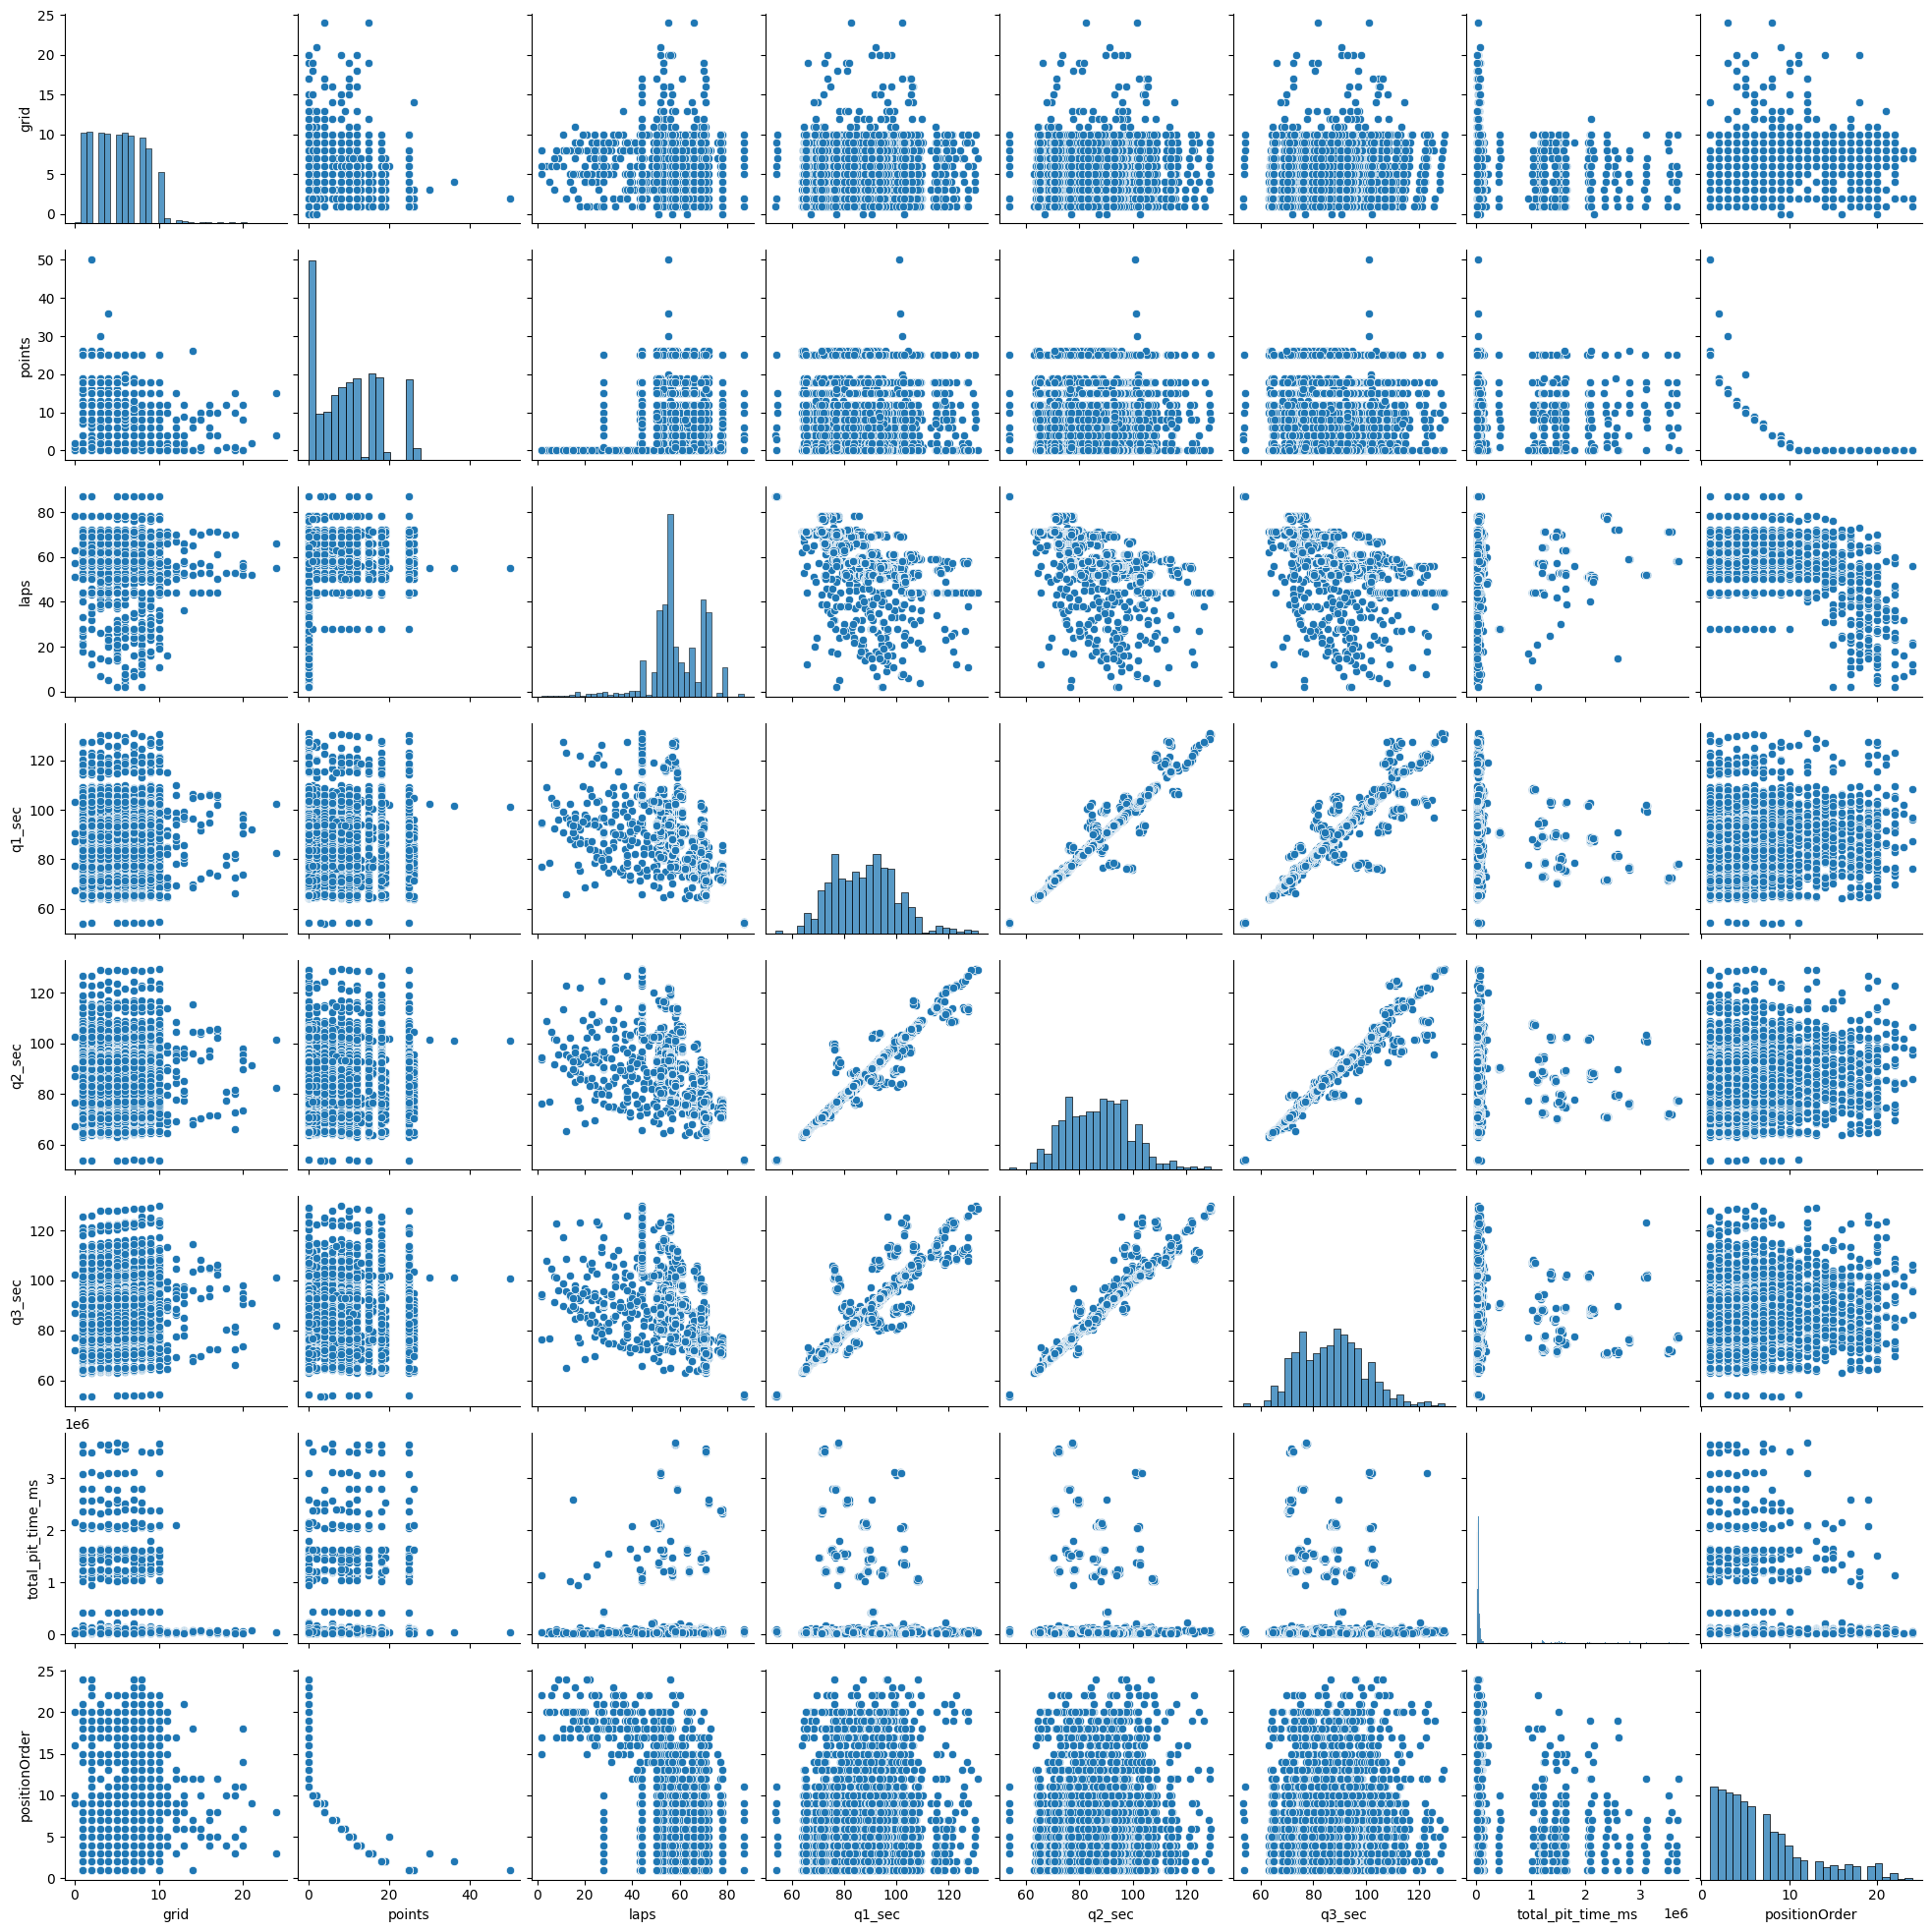

In [12]:
sns.pairplot(merged)
plt.show()

Correlaciones evidentes entre algunas variables:
Se observa una relación muy fuerte entre los tiempos de clasificación (q1_sec, q2_sec, q3_sec). Esto es completamente lógico, ya que pertenecen al mismo proceso de clasificación, donde normalmente un piloto que es rápido en Q1 también lo será en Q2 y Q3.

Relaciones con la posición final (positionOrder):
La variable positionOrder tiene una relación inversa visible con los points: Esto quiere decir, que los pilotos que obtienen más puntos tienden a tener mejores posiciones.
También hay una relación positiva (aunque más débil) con la variable grid, lo que sugiere que los pilotos que parten más atrás usualmente terminan en posiciones más bajas.

Distribución sesgada de variables:
Las distribuciones de variables como points, grid, y positionOrder muestran que muchos pilotos terminan en posiciones alejadas del podio y obtienen pocos o ningún punto. Esto refleja bien la realidad de la Fórmula 1, donde pocos pilotos dominan la mayoría de carreras.

Variables sin relación clara:
La variable total_pit_time_ms no muestra patrones evidentes con ninguna otra variable. Su comportamiento es bastante disperso, lo que indica que no tiene una relación lineal directa clara con la variable dependiente, es decir, no afecta ni aporta al modelo en general.

